In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install seqeval==0.0.5
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install --upgrade gensim
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 45 kB/s 
     |████████████████████████████████| 50 kB 8.6 MB/s 
     |████████████████████████████████| 3.1 MB 54.8 MB/s 
     |████████████████████████████████| 488 kB 81.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
    Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
      Successfully uninsta

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import pandas as pd
import numpy as np
import re

import gensim
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import tensorflow as tf
from nltk import word_tokenize

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Nguyen Dinh Phuc Dai/Data/CVs/Labeled Data/CV Parser - Labeled Data.csv')
print(data[0:20])

       cv                                               line  tag
0   1.pdf                                    Trinh Dinh Phuc  B-I
1   1.pdf                                   Curriculum Vitae  I-I
2   1.pdf                                16 Kha Van Can Str.  I-I
3   1.pdf                           Linh Dong, Thu Duc, HCMC  I-I
4   1.pdf                                                  H  I-I
5   1.pdf                                      0121 658 5084  I-I
6   1.pdf                                                  B  I-I
7   1.pdf                               Phuccoi996@gmail.com  I-I
8   1.pdf                                DOB: March 16, 1996  I-I
9   1.pdf                                          Education  B-E
10  1.pdf  2014–2018 Bachelor’s Degree of Information Tec...  I-E
11  1.pdf  Telecommunications University (TCU), Nha Trang...  I-E
12  1.pdf                    - CGPA: 3.35/4 via 204 credits.  I-E
13  1.pdf   Thesis: Pneumonia Diagnosis using Lung’s XRay...  I-E
14  1.pdf 

In [8]:
print("Shape of array: ", data.shape)
print("Total number of CVs: ", data["cv"].nunique())

Shape of array:  (36461, 3)
Total number of CVs:  450


In [9]:
def decontracted(phrase):
    # specific
    phrase = re.sub(":|-\s+|,|–\s+|-|\||\/", " ", phrase)
    phrase = re.sub(r"â€|™|“|”|;|ü|\xad|\xa0|\u200b|·|∙|�|●|�|§|•|!|▪|©|\?|\]|\[|\)|\(", "", phrase)
    phrase = re.sub(r"[^\w\s]", " ", phrase)
 
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    phrase = re.sub(r"\bhcmc\b", "ho chi minh city ", phrase)
    phrase = re.sub(r"\bhcm\b", "ho chi minh ", phrase)
    phrase = re.sub(r"\bbs\b ", "bachelor of ", phrase)
    phrase = re.sub(r"r’s", "r of", phrase)
    phrase = re.sub(r"\’s", " of", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " of", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\bim\b", "i am ", phrase)
    phrase = re.sub(r"\bi’m\b", "i am ", phrase)
    
    return phrase

In [10]:
line = []
for i in data['line']:
    raw_clean = decontracted(str(i).lower())
    line.append(raw_clean.strip())

In [11]:
line

['trinh dinh phuc',
 'curriculum vitae',
 '16 kha van can str',
 'linh dong  thu duc  ho chi minh city',
 'h',
 '0121 658 5084',
 'b',
 'phuccoi996 gmail com',
 'dob  march 16  1996',
 'education',
 '2014 2018 bachelor s degree of information technology department of computer science',
 'telecommunications university tcu  nha trang  khanh hoa  vietnam',
 'cgpa  3 35 4 via 204 credits',
 'thesis  pneumonia diagnosis using lung s xray with depthwise convolution',
 'final grade  91 100 top of the class',
 'internship',
 '03 2018  machine learning engineer intern part time intern cbd robotics  125 dong van',
 'cong str  district 2  ho chi minh city  vietnam',
 'work learn about and work on the technical side with focus on data analytics with using machine',
 'learning  deep learning',
 'mini projects house price prediction  amazon reviews  airline arrivals  boston marathon  author',
 'classification',
 '04 2018  7 2018 data analyst intern full time intern devnet  101b mai xuan thuong  vinh

In [12]:
wv = KeyedVectors.load('/content/drive/MyDrive/Nguyen Dinh Phuc Dai/Build_Vocabulary/word2vec_v8.bin', mmap='r')

In [13]:
def sent2idx(x):
    xidx = []
    for w in word_tokenize(x):
        if w in wv.key_to_index:
            xidx.append(wv.key_to_index[w])
    return np.array(xidx)

In [14]:
s2v = []
for i in line:
    s2v.append(sent2idx(i))

s2v

[array([1363,  575, 1155]),
 array([253, 271]),
 array([ 501, 3516,  234,   95, 2146]),
 array([921, 522, 456, 337,  13,  15,  10,  21]),
 array([973]),
 array([8357, 8356, 8355]),
 array([341]),
 array([6967,   50,   16]),
 array([1262,  491,  501,  965]),
 array([40]),
 array([ 55,  44, 190, 154, 295,   1,  32,  31, 290,   1,  73,  68]),
 array([ 518,   12, 8350, 1765, 1346, 1145,  316,   34]),
 array([4286,   72, 2040,   81,  416, 6971, 8346]),
 array([ 375, 6972, 3495,   37, 4206,  154, 4159,    7, 6973, 4146]),
 array([ 942,  790, 2537,  836,  622,    1,    3,  427]),
 array([239]),
 array([ 577,   44,  155,   63,   92,  348,  373,  107,  348, 8362, 1304,
        6976,  522,  234]),
 array([ 922, 2146,   90,   56,   13,   15,   10,   21,   34]),
 array([  17,  129,   60,    0,   17,   19,    3,   88, 1221,    7, 1413,
          19,   23,  707,    7,   37,  155]),
 array([ 63, 306,  63]),
 array([2075,   76, 1255, 1291, 1378, 1130, 2541, 8375, 8372, 8371, 6981,
        4427]),
 arr

In [15]:
for i, x in enumerate(s2v):
    if len(x) < 64:
        s2v[i] = np.hstack((x, np.zeros(64-len(x))))
X = np.array(s2v)
X[0]

array([1363.,  575., 1155.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.])

In [19]:
tag = data['tag']

tags = list(set(data['tag'].to_list()))

tag2idx = {tok:idx for  idx, tok in enumerate(tags)}
idx2tag = {idx:tok for  idx, tok in enumerate(tags)}

tag2idx = {'I-W': 0, 'nan': 1, 'B-SU': 2, 'I-S': 3, 'B-I': 4, 'I_I': 5, 'B-S': 6, 'I-I': 7, 'I-E': 8, 'I-SU': 9, 'B-E': 10, 'B-Su': 11, 'O': 12, 'B-W': 13} 
idx2tag = {0: 'I-W', 1: 'nan', 2: 'B-SU', 3: 'I-S', 4: 'B-I', 5: 'I_I', 6: 'B-S', 7: 'I-I', 8: 'I-E', 9: 'I-SU', 10: 'B-E', 11: 'B-Su', 12: 'O', 13: 'B-W'}

n_tags = len(tag2idx)
print(tag2idx, '\nn_tag:' ,n_tags)

{'I-W': 0, 'nan': 1, 'B-SU': 2, 'I-S': 3, 'B-I': 4, 'I_I': 5, 'B-S': 6, 'I-I': 7, 'I-E': 8, 'I-SU': 9, 'B-E': 10, 'B-Su': 11, 'O': 12, 'B-W': 13} 
n_tag: 14


In [17]:
y_tag = list(data['tag'].to_list())
yidx = []
for w in y_tag:
    if w in tag2idx:
        yidx.append([tag2idx[w]])
# y = np.array(yidx)
y = yidx
np.array(y).shape, y[0]

((36461, 1), [4])

In [20]:
for i, x in enumerate(y):
    if len(x) < 64:
        y[i] = np.hstack((x, np.zeros(64-len(x))))
y = np.array(y)
y.shape, y[0]

((36461, 64),
 array([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [21]:
y = [tf.keras.utils.to_categorical(i, num_classes=n_tags) for i in y]
y = np.array(y)
y.shape, y[0]

((36461, 64, 14),
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [22]:
X.shape

(36461, 64)

In [23]:
y.shape

(36461, 64, 14)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, np.array(y_train).shape, np.array(y_test).shape

((25522, 64), (10939, 64), (25522, 64, 14), (10939, 64, 14))

In [25]:
X_train[1], np.array(y_train[1])

(array([127.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0

# **Build_Model**

In [26]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

import keras as k
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

input = Input(shape=(64,))

# Embedding Layer
model = Embedding(input_dim=X.shape[0], output_dim=64, input_length=64)(input)

# model = Bidirectional(LSTM(units=64, 
#                            return_sequences=True,  
#                            recurrent_dropout=0.1,
#                            activation='tanh'), merge_mode='sum')(model)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=64, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5,
                           kernel_initializer=k.initializers.he_normal()))(model)

# model = Bidirectional(LSTM(units=64, 
#                            return_sequences=True, 
#                            dropout=0.5, 
#                            recurrent_dropout=0.5,
#                            kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=64, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5,
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005)

# Compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss=crf_loss, metrics=[crf_viterbi_accuracy, 'acc'])

model.summary()

Using TensorFlow backend.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 64)            2333504   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 128)           66048     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 64)            49408     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 14)            910       
_______________________________________________________________

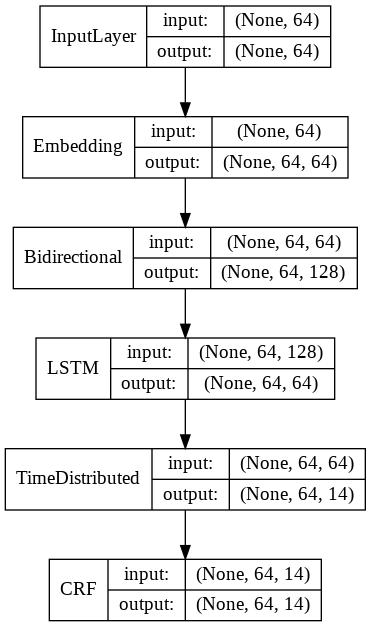

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [28]:
hist = model.fit(X_train, y_train, batch_size=256, epochs=20, validation_split=0.3)

Train on 17865 samples, validate on 7657 samples
Epoch 1/20
17865/17865 [==============================] - 88s 5ms/step - loss: 0.4819 - crf_viterbi_accuracy: 0.8779 - acc: 0.9901 - val_loss: 0.0412 - val_crf_viterbi_accuracy: 0.9901 - val_acc: 0.9901
Epoch 2/20
17865/17865 [==============================] - 81s 5ms/step - loss: 0.0385 - crf_viterbi_accuracy: 0.9901 - acc: 0.9901 - val_loss: 0.0364 - val_crf_viterbi_accuracy: 0.9901 - val_acc: 0.9901
Epoch 3/20
17865/17865 [==============================] - 79s 4ms/step - loss: 0.0359 - crf_viterbi_accuracy: 0.9901 - acc: 0.9901 - val_loss: 0.0342 - val_crf_viterbi_accuracy: 0.9901 - val_acc: 0.9901
Epoch 4/20
17865/17865 [==============================] - 81s 5ms/step - loss: 0.0338 - crf_viterbi_accuracy: 0.9901 - acc: 0.9901 - val_loss: 0.0319 - val_crf_viterbi_accuracy: 0.9901 - val_acc: 0.9901
Epoch 5/20
17865/17865 [==============================] - 79s 4ms/step - loss: 0.0318 - crf_viterbi_accuracy: 0.9901 - acc: 0.9901 - val_lo

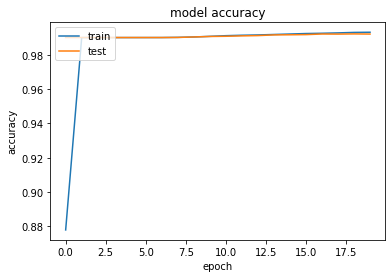

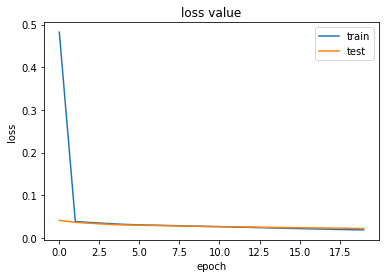

In [29]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(hist.history['crf_viterbi_accuracy'])
plt.plot(hist.history['val_crf_viterbi_accuracy'])

# plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("model_accuracy_lr.png")
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss value')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
# plt.savefig("model_loss_lr.png")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Nguyen Dinh Phuc Dai/Build_Model_Segment/bilstm_crf_v4.h5')